In [34]:
import torch
from torch import nn
import torch_geometric
from torch_geometric.nn import SAGEConv, GraphConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import pandas as pd 
import pickle
import pdb
from torch_geometric.loader import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj, subgraph, k_hop_subgraph
import matplotlib.pyplot as plt
from tools.combine_nx_to_dataloader import GraphDataset
torch.manual_seed(42)

In [35]:
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels * 2)
        self.conv3 = SAGEConv(hidden_channels * 2, hidden_channels)  # Additional hidden layer
        self.conv4 = nn.Linear(hidden_channels, out_channels)  # Final Layer

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x)
        return x

class GraphDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphDecoder, self).__init__()
        # Assuming the encoded features are to be decoded back to original feature size
        self.conv1 = SAGEConv(out_channels, hidden_channels * 2)
        self.conv2 = SAGEConv(hidden_channels * 2, hidden_channels * 2)  # Mimic encoder complexity
        self.conv3 = SAGEConv(hidden_channels * 2, hidden_channels)  # Additional hidden layer
        self.conv4 = nn.Linear(hidden_channels, in_channels)  # Additional hidden layer to output size

    def forward(self, z, edge_index):
        # pdb.set_trace()
        z = F.relu(self.conv1(z, edge_index))
        z = F.relu(self.conv2(z, edge_index))
        z = F.relu(self.conv3(z, edge_index))
        z = self.conv4(z)
        return z

class MaskedGraphAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MaskedGraphAutoencoder, self).__init__()
        self.encoder = GraphEncoder(in_channels, hidden_channels, out_channels)
        self.decoder = GraphDecoder(in_channels, hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x_masked = x #* mask
        z = self.encoder(x_masked, edge_index)
        x_reconstructed = self.decoder(z, edge_index)
        return x_reconstructed, z

In [36]:
def train(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    embeddings = []
    origs = []
    for data in data_loader:
        optimizer.zero_grad()
        reconstructed_x, embed = model(data[0][0], data[1][0])
        origs.append(data[0][0])
        # pdb.set_trace()
        loss = loss_function(reconstructed_x, data[0][0], embed)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        embeddings.append(embed.detach())
    return total_loss / len(data_loader), embeddings, origs

# Assuming a loss function appropriate for node feature reconstruction, e.g., MSE for continuous features
def loss_function(reconstructed_x, original_x, emb):
    lambda_diversity = 0.2
    return F.mse_loss(reconstructed_x, original_x) + lambda_diversity * diversity_loss(emb)


def diversity_loss(embeddings):
    # Calculate pairwise Euclidean distances
    pairwise_distances = torch.pdist(embeddings, p=2)
    # Encourage distances to be greater than a threshold
    threshold  = 1
    diversity_penalty = torch.relu(threshold - pairwise_distances).mean()
    return diversity_penalty


In [37]:
# Example usage
if __name__ == "__main__":

    folder_graph = './graphs/graphsage_graph/single_graphs/'
    fname = 'graph_list_with_features.pth'

    hC = 64
    inC = 40 

    '''
    print(f"radius: {nx.radius(G)}")
    print(f"diameter: {nx.diameter(G)}")
    # print(f"eccentricity: {nx.eccentricity(G)}")
    print(f"center: {nx.center(G)}")
    # print(f"periphery: {nx.periphery(G)}")
    # print(f"density: {nx.density(G)}")
    print(f"max degree: {np.max(G.degree())}")
    '''
    # Convert networkx graph to PyTorch Geometric graph    
    # trainG, testG = get_test_train(G, num_test_nodes=0)
    # trainPyG = networkx_to_pyg_graph(trainG, 'x', 'weight')
    # testPyG = get_test_train(testG, 'x')
 
    graph_list = torch.load(fname)
    dataset = GraphDataset(graph_list)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    actuals = []
    final_loss = []
    embeddings = []
    for outchannels in range(2,5):
        model = MaskedGraphAutoencoder(in_channels=inC, hidden_channels=hC, out_channels=outchannels)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        losses = []
        embeds = []
        acts = []
        for epoch in range(1, 20):  # Number of epochs
            loss, embeds, orig = train(model, dataloader, optimizer)
            embeds.append(embeds)
            acts.append(orig)
            print(f'Epoch {epoch}, Loss: {loss:.4f}')
            losses.append(loss)
        embeddings.append(embeds)
        final_loss.append(losses)
        actuals.append(acts)
        # Assuming encoder and decoder are your model's components
        encoder_state_dict = model.encoder.state_dict()
        decoder_state_dict = model.decoder.state_dict()

        # Save the state dictionaries
        torch.save(encoder_state_dict, 'encoder_state_dict'+str(outchannels)+'.pth')
        torch.save(decoder_state_dict, 'decoder_state_dict'+str(outchannels)+'.pth')

    # print(final_loss)
    np.save('gaelossarray_sage_no_weights_3_4_with_embeds.npy', final_loss)
    # pdb.set_trace()
    fl = open('embeddings_3_4.pickle', 'wb')
    pickle.dump(embeddings, fl)
    fl.close()

    fl = open('actuals_3_4.pickle', 'wb')
    pickle.dump(actuals, fl)
    fl.close()


    # np.save('embeddings.npy', embeddings.numpy()) 
    # print(range(5,20))
        

Epoch 1, Loss: 0.2626
Epoch 2, Loss: 0.1461
Epoch 3, Loss: 0.1149
Epoch 4, Loss: 0.1200
Epoch 5, Loss: 0.1178
Epoch 6, Loss: 0.1019
Epoch 7, Loss: 0.1020
Epoch 8, Loss: 0.0963
Epoch 9, Loss: 0.0963
Epoch 10, Loss: 0.1242
Epoch 11, Loss: 0.0990
Epoch 12, Loss: 0.1024
Epoch 13, Loss: 0.0975
Epoch 14, Loss: 0.1039
Epoch 15, Loss: 0.0992
Epoch 16, Loss: 0.0965
Epoch 17, Loss: 0.0993
Epoch 18, Loss: 0.0953
Epoch 19, Loss: 0.1005
Epoch 1, Loss: 0.2810
Epoch 2, Loss: 0.1556
Epoch 3, Loss: 0.1234
Epoch 4, Loss: 0.1503
Epoch 5, Loss: 0.1634
Epoch 6, Loss: 0.1551
Epoch 7, Loss: 0.1389
Epoch 8, Loss: 1.4355
Epoch 9, Loss: 0.2839
Epoch 10, Loss: 0.2713
Epoch 11, Loss: 0.3427
Epoch 12, Loss: 0.5102
Epoch 13, Loss: 0.5092
Epoch 14, Loss: 0.5093
Epoch 15, Loss: 0.5100
Epoch 16, Loss: 0.5097
Epoch 17, Loss: 0.5091
Epoch 18, Loss: 0.5096
Epoch 19, Loss: 0.5094
Epoch 1, Loss: 0.3261
Epoch 2, Loss: 0.1533
Epoch 3, Loss: 0.1416
Epoch 4, Loss: 0.1344
Epoch 5, Loss: 0.1117
Epoch 6, Loss: 0.1135
Epoch 7, Los

In [38]:
del encoder_state_dict
del decoder_state_dict
del dataloader
del dataset
del embeddings
del embeds
del graph_list 

import gc
gc.collect()

674899

In [39]:
del model
del final_loss
del losses
gc.collect()

564

In [40]:
encoder_dict = torch.load('encoder_state_dict3.pth')
decoder_dict = torch.load('decoder_state_dict3.pth')



In [41]:
in_channels = 40
hidden_channels = 64
out_channels = 3
GAE = MaskedGraphAutoencoder(in_channels, hidden_channels, out_channels)
GAE.encoder.load_state_dict(encoder_dict)
GAE.decoder.load_state_dict(decoder_dict)

# fil =  open('embeddings_3_5.pickle', 'rb')
# embed = pickle.load(fil)   
# fil.close() 
# emb = embed[1]
# # print(len(emb[0]))
# fil =  open('actuals_3_5.pickle', 'rb')
# original = pickle.load(fil)   
# fil.close() 

<All keys matched successfully>

In [42]:
df = pd.read_csv('metadata_graphsage_nodes.csv')
from ast import literal_eval
df.nodeID = df.nodeID.apply(literal_eval)
inp = []
col = []
emb = []
COLORS = {'H':'b', 'S':'g', 'F':'r', 'I':'b'}
for node in df.iterrows():
    # pdb.set_trace()
    inp.append(torch.tensor([[node[1][1]]]))
    col.append(COLORS[node[1][-1]])

for i in inp: 
    emb.append(GAE.encoder(i, torch.empty((2,0), dtype=torch.int64)).detach().tolist())


In [43]:
x = []
y = []
z = []
c = []
for e, cl in zip(emb,col):
    x.append(e[0][0][0])
    y.append(e[0][0][1])
    z.append(e[0][0][2])
    c.append(cl)


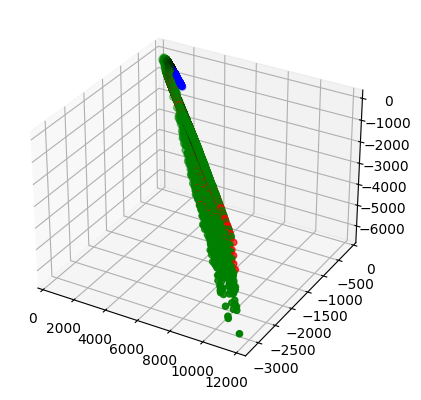

In [50]:
# # %matplotlib notebook
# from IPython.display import HTML
# from matplotlib import animation
%matplotlib inline  
# %matplotlib notebook
# %pylab

# def animate(frame):
#   ax.view_init(30, frame/4)
#   plt.pause(.001)
#   return fig


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(x, y, z, color=c)
# plt.show()
plt.savefig('new.png')
# anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
# HTML(anim.to_html5_video())

# plt.plot3(x,y,z,c=c)

In [ ]:
# result = GAE.encoder(original_input, torch.empty((2,0), dtype=torch.int64))
# print(original_input)
# print(result)

In [9]:
# e = emb[0][0].tolist()
# print(emb[0])
# # print(e[0].tolist())
# print(original[0][0][0][0])

tensor([[0.6899, 3.8092],
        [0.8655, 4.8483],
        [0.6520, 3.5848],
        [0.6274, 3.4393],
        [0.6382, 3.5034],
        [0.6238, 3.4181],
        [0.5995, 3.2746],
        [0.8384, 4.6879],
        [0.8023, 4.4742],
        [0.5978, 3.2640],
        [0.4694, 2.5042],
        [0.5848, 3.1874],
        [0.4171, 2.1951],
        [0.5699, 3.0993],
        [0.7785, 4.3333],
        [0.7704, 4.2854],
        [0.6392, 3.5094],
        [0.6047, 3.3048],
        [0.5704, 3.1022],
        [0.5622, 3.0537],
        [0.3867, 2.0147],
        [0.3390, 1.7328],
        [0.2493, 1.2020],
        [0.3571, 1.8396],
        [0.3441, 1.7630],
        [0.3353, 1.7109],
        [0.7546, 4.1923],
        [0.3446, 1.7656],
        [0.7442, 4.1306],
        [0.3781, 1.9643],
        [0.3351, 1.7095],
        [0.2432, 1.1656],
        [0.5398, 2.9212],
        [0.3317, 1.6898],
        [0.7371, 4.0883],
        [0.5623, 3.0539],
        [0.3877, 2.0208],
        [0.3292, 1.6749],
        [0.2

In [ ]:
# torch.empty((2,1), dtype=torch.int)

tensor([[0],
        [0]], dtype=torch.int32)

In [ ]:
# original_input = torch.tensor([[original[0][0][0][0].tolist()]])
# print(original_input)

tensor([[[ 0.0000, -0.1500,  0.0000,  0.5810,  0.0000, -0.1500,  0.0000,
           0.5810,  0.0000, -0.1500,  0.0000,  0.5810,  0.0000, -0.1500,
           0.0000,  0.5810,  0.0000, -0.1500,  0.0000,  0.5810,  0.0000,
          -0.1500,  0.0000,  0.5810,  3.0000, -0.1500,  0.0000,  0.5810,
           3.0000, -0.1500,  0.0000,  0.5810,  3.0000, -0.1500,  0.0000,
           0.5810,  3.0000, -0.1500,  0.0000,  0.5810]]])


In [ ]:
# input = torch.tensor([[e]])
# result = GAE.encoder(original_input, torch.empty((2,0), dtype=torch.int64))
# print(original_input)
# print(result)

tensor([[[ 0.0000, -0.1500,  0.0000,  0.5810,  0.0000, -0.1500,  0.0000,
           0.5810,  0.0000, -0.1500,  0.0000,  0.5810,  0.0000, -0.1500,
           0.0000,  0.5810,  0.0000, -0.1500,  0.0000,  0.5810,  0.0000,
          -0.1500,  0.0000,  0.5810,  3.0000, -0.1500,  0.0000,  0.5810,
           3.0000, -0.1500,  0.0000,  0.5810,  3.0000, -0.1500,  0.0000,
           0.5810,  3.0000, -0.1500,  0.0000,  0.5810]]])
tensor([[[0.0000, 0.0000, 6.6842]]], grad_fn=<ReluBackward0>)


In [ ]:
# input = torch.tensor([[e]])
# result = GAE.decoder(input, torch.empty((2,0), dtype=torch.int64))
# print(input)
# print(result)
# for i in range(0,5):
#     print(e[i])
#     print(result[i])

tensor([[[0.0000, 0.0000, 0.5841, 0.0000]]])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.3101, 0.0000, 0.0000, 0.6715,
          0.5578, 0.0000, 0.0000, 0.6770, 0.8943, 0.0000, 0.0000, 0.6568,
          1.3684, 0.0000, 0.0000, 0.0000, 1.8016, 0.0000, 0.0000, 0.6539,
          2.2844, 0.0000, 0.0000, 0.6016, 2.6953, 0.0000, 0.0000, 0.5784,
          3.4477, 0.2503, 0.3357, 0.0000, 4.9098, 1.0378, 1.0295, 0.0000]]],
       grad_fn=<ReluBackward0>)


In [ ]:
# result = GAE.decoder(e, torch.empty((2,0), dtype=torch.int64))
# for i in range(0,5):
#     print(e[i])
#     print(result[i])

tensor([0.0000, 0.0000, 0.5841, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3101, 0.0000, 0.0000, 0.6715, 0.5578,
        0.0000, 0.0000, 0.6770, 0.8943, 0.0000, 0.0000, 0.6568, 1.3684, 0.0000,
        0.0000, 0.0000, 1.8016, 0.0000, 0.0000, 0.6539, 2.2844, 0.0000, 0.0000,
        0.6016, 2.6953, 0.0000, 0.0000, 0.5784, 3.4477, 0.2503, 0.3357, 0.0000,
        4.9098, 1.0378, 1.0295, 0.0000], grad_fn=<SelectBackward0>)
tensor([0.0000, 0.0000, 0.1196, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8237, 0.0000,
        0.0000, 0.0000, 0.8369, 0.0000, 0.0000, 0.0000, 0.7865, 0.3559, 0.0000,
        0.0000, 0.0000, 0.7825, 0.0000, 0.0000, 0.7615, 1.6295, 0.0000, 0.0000,
        0.6953, 2.0372, 0.0000, 0.0000, 0.7430, 2.3667, 0.0000, 0.0000, 0.0000,
        4.7823, 1.0200, 0.9818, 0.0000], grad_fn=<SelectBackward0>)
tensor([0.0000, 0.0000, 0.1196, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8237, 0.0000,
        0.0000, 0.000